#펀딩피 노림형 탐지 2차 시도

① 거래(Open/Close)를 포지션 단위로 재구성

② 포지션마다 다음 펀딩 이벤트 시간 매칭

③ 펀딩 직전(0~10분) 진입한 포지션만 의심 후보로 필터링

④ 그중 실제 펀딩피를 받은 포지션만 남김

⑤ 계정별 펀딩피 수령 총합으로 상위 의심 계정 선별

⑥ 계정별 요약 통계로 패턴 검증

⑦ 시각화 및 타임라인으로 펀딩 노림형 행태 확인

In [45]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

base_dir = '/content/drive/MyDrive/싱가포르/data/'

# Trade / Funding CSV 새로 읽기
trade = pd.read_csv(base_dir + 'Trade.csv')
funding = pd.read_csv(base_dir + 'Funding.csv')

print("Trade:", trade.shape)
print("Funding:", funding.shape)
display(trade.head())
display(funding.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Trade: (52953, 10)
Funding: (52694, 4)


,account_id,ts,symbol,side,openclose,position_id,leverage,price,qty,amount
0,A_c668740478,2025-03-01 00:04:14.329767,BTCUSDT.PERP,LONG,OPEN,P_9ecd54214c,50,84303.5,0.177839,14992.450136
1,A_c668740478,2025-03-01 00:09:08.199617,BTCUSDT.PERP,LONG,CLOSE,P_9ecd54214c,0,84321.0,0.177839,14995.562319
2,A_7e27164ab6,2025-03-01 00:23:25.371503,BTCUSDT.PERP,LONG,OPEN,P_fbe21fd2c4,2,84369.2,0.002787,235.136960
3,A_c668740478,2025-03-01 00:30:03.218306,BTCUSDT.PERP,LONG,OPEN,P_9567d3d1d3,50,84243.3,0.178533,15040.209079
4,A_c668740478,2025-03-01 00:34:38.392647,BTCUSDT.PERP,LONG,CLOSE,P_9567d3d1d3,0,84121.0,0.178533,15018.374493


,account_id,ts,fee_rate,funding_fee
0,A_06d5bd3da9,2025-03-01 00:00:00.348937,0.000050,0.000063
1,A_06d5bd3da9,2025-03-01 00:00:00.348937,0.000050,0.000063
2,A_40cfe40ac2,2025-03-01 00:00:00.806171,0.000100,-0.065085
3,A_7e27164ab6,2025-03-01 00:00:00.889929,0.000022,0.000403
4,A_ebdb869fd3,2025-03-01 00:00:00.889929,0.000022,0.000037


In [46]:
# 시간 형식 변환
trade['ts'] = pd.to_datetime(trade['ts'])

# OPEN / CLOSE 분리
open_tr = trade[trade['openclose'].str.upper() == 'OPEN'].copy()
close_tr = trade[trade['openclose'].str.upper() == 'CLOSE'].copy()

# 첫 OPEN
open_pos = (open_tr.sort_values('ts')
            .groupby(['account_id','position_id'], as_index=False)
            .first())

# 마지막 CLOSE
close_pos = (close_tr.sort_values('ts')
             .groupby(['account_id','position_id'], as_index=False)
             .last())

# 컬럼 이름 정리
open_pos = open_pos.rename(columns={'ts': 'ts_open', 'amount': 'amount_open'})
close_pos = close_pos.rename(columns={'ts': 'ts_close', 'amount': 'amount_close'})

# 포지션 병합
pos = pd.merge(
    open_pos[['account_id','position_id','symbol','side','leverage','ts_open','amount_open']],
    close_pos[['account_id','position_id','ts_close','amount_close']],
    on=['account_id','position_id'],
    how='left'
)

# 보유시간 계산
pos['holding_minutes'] = (pos['ts_close'] - pos['ts_open']).dt.total_seconds() / 60.0

print("포지션 수:", len(pos))
display(pos.head())

포지션 수: 24356


,account_id,position_id,symbol,side,leverage,ts_open,amount_open,ts_close,amount_close,holding_minutes
0,A_06d5bd3da9,P_036abd0638,ETHUSDT.PERP,SHORT,20,2025-07-15 13:04:02.178026,1624.710272,2025-07-15 14:51:39.891984,4215.876392,107.628566
1,A_06d5bd3da9,P_04962c21d2,ETHUSDT.PERP,SHORT,100,2025-07-02 18:38:23.667200,4672.947168,2025-07-02 19:56:29.332730,4696.182136,78.094425
2,A_06d5bd3da9,P_05863054b7,ETHUSDT.PERP,LONG,100,2025-07-02 17:26:09.714703,4175.866450,2025-07-02 17:26:50.927852,4180.776565,0.686886
3,A_06d5bd3da9,P_05e7554f4e,SOLUSDT.PERP,LONG,30,2025-07-23 17:46:19.948006,852.570180,2025-07-23 21:37:52.612552,1667.184480,231.544409
4,A_06d5bd3da9,P_0786ddfd93,ETHUSDT.PERP,LONG,40,2025-07-10 07:31:31.447114,5922.376107,2025-07-10 21:25:44.391404,24592.549569,834.215738


In [47]:
# 펀딩 시간 변환
funding['ts'] = pd.to_datetime(funding['ts'])
funding = funding.rename(columns={'ts': 'fund_ts'})

# 정렬
pos_sorted = pos.sort_values(['account_id','ts_open'])
fund_sorted = funding.sort_values(['account_id','fund_ts'])

nearest_list = []

# 계정별 merge_asof
for acc, g in pos_sorted.groupby('account_id'):
    left = g.sort_values('ts_open')
    right = fund_sorted[fund_sorted['account_id'] == acc].sort_values('fund_ts')

    if right.empty:
        continue

    merged = pd.merge_asof(
        left,
        right,
        left_on='ts_open',
        right_on='fund_ts',
        direction='forward',
        allow_exact_matches=True
    )
    nearest_list.append(merged)

nearest = pd.concat(nearest_list, ignore_index=True)

# 펀딩까지 남은 시간(분)
nearest['delta_before_min'] = (nearest['fund_ts'] - nearest['ts_open']).dt.total_seconds() / 60.0

print("펀딩 매칭된 포지션 수:", len(nearest))
display(nearest.head())

펀딩 매칭된 포지션 수: 24222


,account_id_x,position_id,symbol,side,leverage,ts_open,amount_open,ts_close,amount_close,holding_minutes,account_id_y,fund_ts,fee_rate,funding_fee,delta_before_min
0,A_06d5bd3da9,P_48ab5fb777,ETHUSDT.PERP,SHORT,100,2025-07-01 17:12:12.875585,266.974400,2025-07-01 17:15:42.801533,266.709300,3.498766,A_06d5bd3da9,2025-07-02 03:00:00.039673,0.000013,0.000595,587.786068
1,A_06d5bd3da9,P_82bb39601b,ETHUSDT.PERP,LONG,100,2025-07-01 17:16:17.194430,293.575464,2025-07-01 18:52:55.327381,292.100466,96.635549,A_06d5bd3da9,2025-07-02 03:00:00.039673,0.000013,0.000595,583.714087
2,A_06d5bd3da9,P_3a7f522738,ETHUSDT.PERP,LONG,100,2025-07-02 00:46:46.612751,149.863584,2025-07-02 01:17:26.298002,298.279935,30.661421,A_06d5bd3da9,2025-07-02 03:00:00.039673,0.000013,0.000595,133.223782
3,A_06d5bd3da9,P_f44f8b0ab3,ETHUSDT.PERP,LONG,100,2025-07-02 00:49:22.169147,149.884375,2025-07-02 02:20:34.937780,150.401875,91.212811,A_06d5bd3da9,2025-07-02 03:00:00.039673,0.000013,0.000595,130.631175
4,A_06d5bd3da9,P_6d5bc015d5,ETHUSDT.PERP,LONG,100,2025-07-02 01:09:51.766697,299.917500,2025-07-02 01:17:40.346458,298.411250,7.809663,A_06d5bd3da9,2025-07-02 03:00:00.039673,0.000013,0.000595,110.137883


In [49]:
sus_fund = nearest[
    (nearest['delta_before_min'] >= 0) &
    (nearest['delta_before_min'] <= 10)
].copy()

print("펀딩 10분 전 진입 포지션 수:", len(sus_fund))

print("sus_fund columns:", sus_fund.columns.tolist())
display(sus_fund.head())

펀딩 10분 전 진입 포지션 수: 1185
sus_fund columns: ['account_id_x', 'position_id', 'symbol', 'side', 'leverage', 'ts_open', 'amount_open', 'ts_close', 'amount_close', 'holding_minutes', 'account_id_y', 'fund_ts', 'fee_rate', 'funding_fee', 'delta_before_min']


,account_id_x,position_id,symbol,side,leverage,ts_open,amount_open,ts_close,amount_close,holding_minutes,account_id_y,fund_ts,fee_rate,funding_fee,delta_before_min
16,A_06d5bd3da9,P_10cf772c65,ETHUSDT.PERP,SHORT,100,2025-07-02 15:53:12.461996,499.969470,2025-07-02 16:05:06.301006,502.502000,11.897317,A_06d5bd3da9,2025-07-02 16:00:00.270944,0.000093,-0.046476,6.796816
43,A_06d5bd3da9,P_40bddf766c,ETHUSDT.PERP,SHORT,40,2025-07-07 07:54:07.260225,1624.339827,2025-07-07 08:19:13.750961,2836.598652,25.108179,A_06d5bd3da9,2025-07-07 08:00:00.365080,0.000197,-0.320112,5.885081
123,A_06d5bd3da9,P_f362a0f882,ZORAUSDT.PERP,SHORT,10,2025-07-26 07:50:26.163005,380.261400,2025-07-26 09:40:09.267786,820.108800,109.718413,A_06d5bd3da9,2025-07-26 08:00:00.342938,0.000050,-0.038193,9.569666
155,A_0ad0445c5a,P_46944511e3,SOMIUSDT.PERP,LONG,6,2025-10-03 11:58:25.405571,11999.960280,2025-10-03 12:02:29.457600,11989.597620,4.067534,A_0ad0445c5a,2025-10-03 12:00:00.467732,-0.004040,-48.462051,1.584369
175,A_0ad0445c5a,P_21fb938804,2ZUSDT.PERP,SHORT,8,2025-10-06 07:54:56.203450,11999.999011,2025-10-06 09:16:45.097913,11984.170198,81.814908,A_0ad0445c5a,2025-10-06 08:00:00.485407,0.000091,-1.097712,5.071366


In [50]:
# sus_fund 계정 컬럼 통합
sus_fund['account_id'] = sus_fund['account_id_x'].fillna(sus_fund['account_id_y'])

# 필요 없어진 x, y 컬럼은 정리해도 됨
sus_fund = sus_fund.drop(columns=['account_id_x', 'account_id_y'])

print("정리 후 sus_fund columns:", sus_fund.columns.tolist())

정리 후 sus_fund columns: ['position_id', 'symbol', 'side', 'leverage', 'ts_open', 'amount_open', 'ts_close', 'amount_close', 'holding_minutes', 'fund_ts', 'fee_rate', 'funding_fee', 'delta_before_min', 'account_id']


In [51]:
print("펀딩 10분 전 진입 포지션 수:", len(sus_fund))

cols = ['account_id','symbol','ts_open','ts_close',
        'fund_ts','delta_before_min','funding_fee','leverage']
cols = [c for c in cols if c in sus_fund.columns]

if len(sus_fund) > 0:
    display(sus_fund[cols].head())
else:
    print("펀딩 10분 이내에 진입한 포지션이 없습니다.")

펀딩 10분 전 진입 포지션 수: 1185


,account_id,symbol,ts_open,ts_close,fund_ts,delta_before_min,funding_fee,leverage
16,A_06d5bd3da9,ETHUSDT.PERP,2025-07-02 15:53:12.461996,2025-07-02 16:05:06.301006,2025-07-02 16:00:00.270944,6.796816,-0.046476,100
43,A_06d5bd3da9,ETHUSDT.PERP,2025-07-07 07:54:07.260225,2025-07-07 08:19:13.750961,2025-07-07 08:00:00.365080,5.885081,-0.320112,40
123,A_06d5bd3da9,ZORAUSDT.PERP,2025-07-26 07:50:26.163005,2025-07-26 09:40:09.267786,2025-07-26 08:00:00.342938,9.569666,-0.038193,10
155,A_0ad0445c5a,SOMIUSDT.PERP,2025-10-03 11:58:25.405571,2025-10-03 12:02:29.457600,2025-10-03 12:00:00.467732,1.584369,-48.462051,6
175,A_0ad0445c5a,2ZUSDT.PERP,2025-10-06 07:54:56.203450,2025-10-06 09:16:45.097913,2025-10-06 08:00:00.485407,5.071366,-1.097712,8


In [52]:
if len(sus_fund) > 0:
    # 펀딩을 받은 포지션만
    sus_income = sus_fund[sus_fund['funding_fee'] > 0].copy()
    print("펀딩피 수령 포지션 수:", len(sus_income))

    if len(sus_income) == 0:
        print("펀딩피를 받은 포지션이 없습니다.")
    else:
        # 포지션 단위 랭킹
        pos_rank = sus_income.sort_values('funding_fee', ascending=False)
        cols_pos = ['account_id','symbol','ts_open','ts_close',
                    'fund_ts','delta_before_min','funding_fee','leverage']
        cols_pos = [c for c in cols_pos if c in pos_rank.columns]

        print("펀딩피 수령 기준 포지션 TOP 20")
        display(pos_rank[cols_pos].head(20))

        # 계정 단위 랭킹
        acc_rank = (sus_income.groupby('account_id')['funding_fee']
                    .sum()
                    .reset_index()
                    .sort_values('funding_fee', ascending=False))

        print("계정별 펀딩피 수령 합계 TOP 20")
        display(acc_rank.head(20))
else:
    print("분석할 sus_fund가 없습니다.")

펀딩피 수령 포지션 수: 574
펀딩피 수령 기준 포지션 TOP 20


,account_id,symbol,ts_open,ts_close,fund_ts,delta_before_min,funding_fee,leverage
2498,A_0e72128b0d,HUSDT.PERP,2025-07-03 10:56:10.239930,2025-07-03 11:00:16.291282,2025-07-03 11:00:00.085859,3.830765,1713.330361,4
2499,A_0e72128b0d,HUSDT.PERP,2025-07-03 11:50:33.900956,2025-07-03 12:00:07.794063,2025-07-03 12:00:00.218360,9.438623,882.931228,4
19642,A_cab220ef3c,MERLUSDT.PERP,2025-06-11 15:57:47.619354,2025-06-13 07:47:46.433887,2025-06-11 16:00:00.279122,2.210996,590.761867,1
2500,A_0e72128b0d,HUSDT.PERP,2025-07-03 12:55:42.856703,2025-07-03 13:00:32.167264,2025-07-03 13:00:00.085557,4.287148,570.326536,4
13492,A_8413984c30,NEARUSDT.PERP,2025-08-16 07:52:39.372098,2025-08-16 08:56:09.502749,2025-08-16 08:00:00.323560,7.349191,342.695881,13
2502,A_0e72128b0d,HUSDT.PERP,2025-07-03 13:57:23.889732,2025-07-03 14:02:03.227338,2025-07-03 14:00:00.106678,2.603616,306.669329,4
20225,A_d444580218,BIOUSDT.PERP,2025-10-20 12:57:34.764952,2025-10-20 13:02:44.842817,2025-10-20 13:00:00.083130,2.421970,249.608424,10
24087,A_f96ede8d34,BIOUSDT.PERP,2025-10-20 12:57:34.735020,2025-10-20 13:02:43.950398,2025-10-20 13:00:00.083130,2.422468,249.408368,10
19671,A_cab220ef3c,ANIMEUSDT.PERP,2025-06-14 03:53:09.987545,2025-06-14 03:54:05.882559,2025-06-14 04:00:00.185979,6.836641,244.211658,2
19672,A_cab220ef3c,ANIMEUSDT.PERP,2025-06-14 03:55:49.016659,2025-06-17 23:33:29.516990,2025-06-14 04:00:00.185979,4.186155,244.211658,2


계정별 펀딩피 수령 합계 TOP 20


,account_id,funding_fee
1,A_0e72128b0d,3571.486198
34,A_cab220ef3c,3076.969002
42,A_f96ede8d34,2086.288105
36,A_d444580218,2029.199835
41,A_f2ab53d645,555.207473
35,A_cf3fcea289,391.459509
24,A_8413984c30,342.695881
30,A_ae270b7bf6,245.552230
25,A_8860be39b3,161.419162
5,A_26ffea8fd9,104.789607


• 전체 포지션 중 펀딩 시점 10분 전(0~10분) 사이에 진입한 포지션은 1,185개였다.

• 이 가운데 펀딩피를 실제로 수령한 포지션은 574개로,
펀딩 제도로부터 직접적인 이익을 얻은 사례들이다.

• 이 포지션들은 모두 펀딩 이벤트 직전 짧은 시간에 진입했다는 공통점을 가진다.

• 펀딩피 수령 포지션 574개를 계정별로 집계한 결과,
상위 4개 계정이 각각 500~3500 수준의 펀딩피를 수령하였다.

• 특히 A_0e72128b0d, A_cab220ef3c 등 상위 계정은
동일한 날 여러 펀딩 시점 직전에 반복해서 포지션을 진입하는 패턴을 보인다.

-> 이는 일반적인 가격 변동에 따른 거래라기보다는,
펀딩 시점과 방향(롱/숏)을 의도적으로 선택해 제도적 수익을 극대화하려는 시도로 해석할 수 있다.


# 상위 계정 깊게 보기


상위 계정 목록 뽑기

In [53]:
# 계정별 펀딩피 수령 합계 TOP 5 계정
top_acc = acc_rank['account_id'].head(5).tolist()
top_acc

['A_0e72128b0d',
 'A_cab220ef3c',
 'A_f96ede8d34',
 'A_d444580218',
 'A_f2ab53d645']

상위 계정들의 요약 통계 (펀딩 직전 포지션 기준)

In [58]:
top5 = ['A_0e72128b0d','A_cab220ef3c','A_f96ede8d34','A_d444580218','A_f2ab53d645']

summary_top5 = (
    sus_income[sus_income['account_id'].isin(top5)]
    .groupby('account_id')
    .agg(
        n_positions=('account_id', 'size'),                    # 펀딩 직전 + 펀딩 수령 포지션 수
        sum_funding=('funding_fee', 'sum'),                    # 펀딩피 총합
        mean_funding=('funding_fee', 'mean'),                  # 펀딩피 평균
        median_delta_min=('delta_before_min', 'median'),       # 펀딩까지 남은 시간(중앙값)
        median_holding=('holding_minutes', 'median'),          # 보유시간(중앙값)
        median_leverage=('leverage', 'median')                 # 레버리지(중앙값)
    )
    .reset_index()
)

summary_top5

,account_id,n_positions,sum_funding,mean_funding,median_delta_min,median_holding,median_leverage
0,A_0e72128b0d,6,3571.486198,595.247700,4.058957,5.159184,4.0
1,A_cab220ef3c,35,3076.969002,87.913400,5.094617,4178.155685,2.0
2,A_d444580218,36,2029.199835,56.366662,1.009771,0.691224,10.0
3,A_f2ab53d645,13,555.207473,42.708267,6.644793,27.565258,1.0
4,A_f96ede8d34,118,2086.288105,17.680408,1.636689,1.213983,10.0


특정 계정(A_0e72128b0d)의 개별 포지션 타임라인 보기

In [59]:
acc_id = 'A_0e72128b0d'

acc_cases = (sus_income[sus_income['account_id'] == acc_id]
             .sort_values('ts_open'))

display(acc_cases[['symbol','ts_open','ts_close',
                   'fund_ts','delta_before_min',
                   'holding_minutes','funding_fee','leverage']])

,symbol,ts_open,ts_close,fund_ts,delta_before_min,holding_minutes,funding_fee,leverage
2423,BTCUSDT.PERP,2025-04-14 23:58:46.843263,2025-04-15 00:04:16.634797,2025-04-15 00:00:00.473583,1.227172,5.496526,7.644511,10
2494,HUSDT.PERP,2025-07-02 14:54:53.309086,2025-07-02 15:04:49.615747,2025-07-02 15:00:00.110980,5.113365,9.938444,90.584232,2
2498,HUSDT.PERP,2025-07-03 10:56:10.239930,2025-07-03 11:00:16.291282,2025-07-03 11:00:00.085859,3.830765,4.100856,1713.330361,4
2499,HUSDT.PERP,2025-07-03 11:50:33.900956,2025-07-03 12:00:07.794063,2025-07-03 12:00:00.218360,9.438623,9.564885,882.931228,4
2500,HUSDT.PERP,2025-07-03 12:55:42.856703,2025-07-03 13:00:32.167264,2025-07-03 13:00:00.085557,4.287148,4.821843,570.326536,4
2502,HUSDT.PERP,2025-07-03 13:57:23.889732,2025-07-03 14:02:03.227338,2025-07-03 14:00:00.106678,2.603616,4.655627,306.669329,4


각 계정별 개별 포지션 리스트 출력

In [60]:
for acc in top5:
    print("\n","="*60)
    print(f"▶ 계정: {acc} 개별 포지션")
    print("="*60)

    df_acc = (sus_income[sus_income['account_id'] == acc]
              .sort_values('ts_open'))

    display(df_acc[['symbol','ts_open','ts_close',
                    'fund_ts','delta_before_min',
                    'holding_minutes','funding_fee','leverage']])


▶ 계정: A_0e72128b0d 개별 포지션


,symbol,ts_open,ts_close,fund_ts,delta_before_min,holding_minutes,funding_fee,leverage
2423,BTCUSDT.PERP,2025-04-14 23:58:46.843263,2025-04-15 00:04:16.634797,2025-04-15 00:00:00.473583,1.227172,5.496526,7.644511,10
2494,HUSDT.PERP,2025-07-02 14:54:53.309086,2025-07-02 15:04:49.615747,2025-07-02 15:00:00.110980,5.113365,9.938444,90.584232,2
2498,HUSDT.PERP,2025-07-03 10:56:10.239930,2025-07-03 11:00:16.291282,2025-07-03 11:00:00.085859,3.830765,4.100856,1713.330361,4
2499,HUSDT.PERP,2025-07-03 11:50:33.900956,2025-07-03 12:00:07.794063,2025-07-03 12:00:00.218360,9.438623,9.564885,882.931228,4
2500,HUSDT.PERP,2025-07-03 12:55:42.856703,2025-07-03 13:00:32.167264,2025-07-03 13:00:00.085557,4.287148,4.821843,570.326536,4
2502,HUSDT.PERP,2025-07-03 13:57:23.889732,2025-07-03 14:02:03.227338,2025-07-03 14:00:00.106678,2.603616,4.655627,306.669329,4



▶ 계정: A_cab220ef3c 개별 포지션


,symbol,ts_open,ts_close,fund_ts,delta_before_min,holding_minutes,funding_fee,leverage
19382,SYSUSDT.PERP,2025-03-21 11:50:59.096501,2025-03-24 23:54:04.139273,2025-03-21 12:00:00.371358,9.021248,5043.084046,7.614928,2
19385,SYSUSDT.PERP,2025-03-24 23:56:51.200076,2025-03-28 02:46:39.226756,2025-03-25 00:00:00.480497,3.154674,4489.800445,98.075133,2
19386,SYSUSDT.PERP,2025-03-24 23:59:17.961956,2025-03-28 02:53:24.839620,2025-03-25 00:00:00.480497,0.708642,4494.114628,98.075133,2
19389,SYSUSDT.PERP,2025-03-29 03:50:13.913172,2025-04-03 23:44:30.600069,2025-03-29 04:00:00.575515,9.777706,8394.278115,91.759979,2
19390,RIFUSDT.PERP,2025-03-29 07:54:18.247850,2025-03-29 11:55:18.707656,2025-03-29 08:00:00.528172,5.704672,241.007663,103.698767,2
19392,REZUSDT.PERP,2025-03-29 23:55:49.920746,2025-04-17 11:40:52.622999,2025-03-30 00:00:00.541455,4.177012,26625.045038,20.494634,2
19442,ANIMEUSDT.PERP,2025-04-17 03:50:01.699941,2025-04-23 03:51:49.487261,2025-04-17 04:00:00.263644,9.976062,8641.796455,144.617584,2
19443,ONGUSDT.PERP,2025-04-17 03:55:03.182120,2025-04-21 12:59:03.451598,2025-04-17 04:00:00.263644,4.951359,6304.004491,144.617584,2
19444,MEUSDT.PERP,2025-04-17 11:56:39.852095,2025-04-17 23:57:37.600128,2025-04-17 12:00:00.297669,3.340760,720.962467,25.697173,2
19445,AXLUSDT.PERP,2025-04-17 11:59:39.229558,2025-04-22 23:24:46.246424,2025-04-17 12:00:00.297669,0.351135,7885.116948,25.697173,2



▶ 계정: A_f96ede8d34 개별 포지션


,symbol,ts_open,ts_close,fund_ts,delta_before_min,holding_minutes,funding_fee,leverage
23840,ZKCUSDT.PERP,2025-10-01 03:55:54.072116,2025-10-01 04:00:08.627898,2025-10-01 04:00:00.269191,4.103285,4.242596,0.000043,10
23841,0GUSDT.PERP,2025-10-01 03:57:31.191536,2025-10-01 04:00:06.466771,2025-10-01 04:00:00.269191,2.484628,2.587921,0.000043,10
23842,SOMIUSDT.PERP,2025-10-01 07:55:42.457875,2025-10-01 07:57:18.398911,2025-10-01 08:00:00.365121,4.298454,1.599017,0.000044,10
23843,SOMIUSDT.PERP,2025-10-01 07:58:39.795275,2025-10-01 07:58:59.311839,2025-10-01 08:00:00.365121,1.342831,0.325276,0.000044,10
23844,ZKCUSDT.PERP,2025-10-01 07:59:49.158281,2025-10-01 08:00:01.159791,2025-10-01 08:00:00.365121,0.186781,0.200025,0.000044,10
...,...,...,...,...,...,...,...,...
24209,OMUSDT.PERP,2025-10-31 03:56:39.807141,2025-10-31 04:03:11.269818,2025-10-31 04:00:00.425349,3.343637,6.524378,0.000051,20
24217,KAVAUSDT.PERP,2025-10-31 15:56:44.044223,2025-10-31 15:56:46.268607,2025-10-31 16:00:00.652970,3.276812,0.037073,0.000052,10
24218,ICNTUSDT.PERP,2025-10-31 15:59:45.711970,2025-10-31 16:00:05.114263,2025-10-31 16:00:00.652970,0.249017,0.323372,0.000052,10
24220,ASRUSDT.PERP,2025-10-31 19:57:11.033994,2025-10-31 19:57:56.906422,2025-10-31 20:00:00.276444,2.820707,0.764540,0.067306,10



▶ 계정: A_d444580218 개별 포지션


,symbol,ts_open,ts_close,fund_ts,delta_before_min,holding_minutes,funding_fee,leverage
20099,SOMIUSDT.PERP,2025-10-04 11:54:48.434686,2025-10-04 11:56:51.474911,2025-10-04 12:00:00.327990,5.198222,2.050670,41.319359,10
20100,SOMIUSDT.PERP,2025-10-04 11:59:50.808094,2025-10-04 12:00:09.679440,2025-10-04 12:00:00.327990,0.158665,0.314522,41.319359,10
20101,OPENUSDT.PERP,2025-10-04 15:57:41.633651,2025-10-04 15:58:07.401918,2025-10-04 16:00:00.617635,2.316400,0.429471,0.000052,10
20111,ASTRUSDT.PERP,2025-10-06 07:57:50.648434,2025-10-06 08:00:13.850634,2025-10-06 08:00:00.486844,2.163973,2.386703,67.822225,10
20119,ASTRUSDT.PERP,2025-10-06 15:59:14.337004,2025-10-06 16:00:05.226516,2025-10-06 16:00:00.528589,0.769860,0.848159,36.510136,10
20141,4USDT.PERP,2025-10-08 15:52:51.283553,2025-10-08 15:53:31.174308,2025-10-08 16:00:00.428976,7.152424,0.664846,82.414859,10
20142,4USDT.PERP,2025-10-08 15:54:21.199524,2025-10-08 16:09:40.853402,2025-10-08 16:00:00.428976,5.653824,15.327565,82.414859,10
20159,INUSDT.PERP,2025-10-10 11:52:51.571817,2025-10-10 11:52:59.614294,2025-10-10 12:00:00.386020,7.146903,0.134041,98.821723,10
20160,SQDUSDT.PERP,2025-10-10 11:59:21.829053,2025-10-10 11:59:38.702278,2025-10-10 12:00:00.386020,0.642616,0.281220,98.821723,10
20161,INUSDT.PERP,2025-10-10 11:59:45.961088,2025-10-10 12:00:05.031622,2025-10-10 12:00:00.386020,0.240416,0.317842,98.821723,10



▶ 계정: A_f2ab53d645 개별 포지션


,symbol,ts_open,ts_close,fund_ts,delta_before_min,holding_minutes,funding_fee,leverage
22475,KAITOUSDT.PERP,2025-03-13 07:56:04.247214,2025-03-15 12:27:11.394155,2025-03-13 08:00:00.872769,3.943759,3151.119116,0.483198,1
22487,FARTCOINUSDT.PERP,2025-03-17 07:51:50.706772,2025-03-17 07:52:10.703884,2025-03-17 08:00:00.584617,8.164631,0.333285,0.127910,1
22566,1000XUSDT.PERP,2025-03-22 23:56:12.518589,2025-03-23 02:59:02.541362,2025-03-23 00:00:00.533372,3.800246,182.833713,0.149516,3
23235,INITUSDT.PERP,2025-04-29 23:52:22.367132,2025-04-30 00:03:22.818726,2025-04-30 00:00:00.736505,7.639490,11.007527,4.265671,1
23274,LAYERUSDT.PERP,2025-05-06 11:52:45.877095,2025-05-06 12:01:57.927081,2025-05-06 12:00:00.254772,7.239628,9.200833,138.292256,1
23275,LAYERUSDT.PERP,2025-05-06 11:54:50.216172,2025-05-06 12:01:57.926255,2025-05-06 12:00:00.254772,5.167310,7.128501,138.292256,1
23287,LAYERUSDT.PERP,2025-05-06 21:50:08.612832,2025-05-07 01:47:20.325776,2025-05-06 22:00:00.135697,9.858714,237.195216,126.879286,1
23288,LAYERUSDT.PERP,2025-05-06 21:51:18.290388,2025-05-07 01:47:15.076200,2025-05-06 22:00:00.135697,8.697422,235.946430,126.879286,1
23314,MOODENGUSDT.PERP,2025-05-09 07:53:22.206547,2025-05-09 09:13:40.940956,2025-05-09 08:00:00.894138,6.644793,80.312240,0.493351,1
23329,MOODENGUSDT.PERP,2025-05-11 07:54:32.063260,2025-05-11 08:05:14.306828,2025-05-11 08:00:01.258185,5.486582,10.704059,2.460420,1


계정별 핵심 특징 자동 도출

In [61]:
def analyze_account(acc):
    df = sus_income[sus_income['account_id'] == acc]
    if df.empty:
        return None

    return {
        'account_id': acc,
        'count_positions': len(df),
        'median_delta_to_funding': df['delta_before_min'].median(),
        'median_holding_min': df['holding_minutes'].median(),
        'median_leverage': df['leverage'].median(),
        'unique_symbols': df['symbol'].nunique(),
        'funding_sum': df['funding_fee'].sum(),
        'funding_mean': df['funding_fee'].mean()
    }

analysis_list = [analyze_account(acc) for acc in top5]
analysis_df = pd.DataFrame(analysis_list)
analysis_df

,account_id,count_positions,median_delta_to_funding,median_holding_min,median_leverage,unique_symbols,funding_sum,funding_mean
0,A_0e72128b0d,6,4.058957,5.159184,4.0,2,3571.486198,595.247700
1,A_cab220ef3c,35,5.094617,4178.155685,2.0,24,3076.969002,87.913400
2,A_f96ede8d34,118,1.636689,1.213983,10.0,40,2086.288105,17.680408
3,A_d444580218,36,1.009771,0.691224,10.0,18,2029.199835,56.366662
4,A_f2ab53d645,13,6.644793,27.565258,1.0,9,555.207473,42.708267


# 결론
● 계정 A_0e72128b0d는 BTCUSDT 및 HUSDT 무기한 선물에서
펀딩 시점 1-9분 전에 포지션에 진입하고,
펀딩 이벤트가 발생한 직후 4~10분 내에 포지션을 청산하는 패턴을 반복적으로 보였다.

● 특히 2025-07-03에는 HUSDT.PERP 종목에서
11시, 12시, 13시, 14시 펀딩 이벤트 직전에 각각 포지션을 열고,
각 펀딩 이벤트 직후 단기 보유 후 청산하여
펀딩피를 네 차례 연속 수령하였다.

● 이 계정의 포지션은 보유 시간이 짧고,
펀딩 시점과의 시간 간격(delta_before_min)이 일관되게 0~10분 이내에 분포하며,
모든 포지션에서 펀딩피가 양수인 점을 고려할 때
가격 변동보다는 펀딩피 수취를 목적으로 한 “펀딩 노림형” 거래 패턴의 가능성이 높다.

# 시각화

In [66]:
import matplotlib.pyplot as plt

acc_id = "A_0e72128b0d"

# 이 계정의 포지션만 추출
acc = sus_income[sus_income['account_id'] == acc_id].copy()
acc = acc.sort_values('ts_open').reset_index(drop=True)

# 펀딩 시점을 0으로 두고, 진입/청산 시점을 '분' 단위 상대값으로 변환
acc['rel_open_min']  = (acc['ts_open']  - acc['fund_ts']).dt.total_seconds() / 60.0
acc['rel_close_min'] = (acc['ts_close'] - acc['fund_ts']).dt.total_seconds() / 60.0

display(acc[['symbol','ts_open','ts_close','fund_ts',
             'rel_open_min','rel_close_min','holding_minutes','funding_fee','leverage']])

,symbol,ts_open,ts_close,fund_ts,rel_open_min,rel_close_min,holding_minutes,funding_fee,leverage
0,BTCUSDT.PERP,2025-04-14 23:58:46.843263,2025-04-15 00:04:16.634797,2025-04-15 00:00:00.473583,-1.227172,4.269354,5.496526,7.644511,10
1,HUSDT.PERP,2025-07-02 14:54:53.309086,2025-07-02 15:04:49.615747,2025-07-02 15:00:00.110980,-5.113365,4.825079,9.938444,90.584232,2
2,HUSDT.PERP,2025-07-03 10:56:10.239930,2025-07-03 11:00:16.291282,2025-07-03 11:00:00.085859,-3.830765,0.270090,4.100856,1713.330361,4
3,HUSDT.PERP,2025-07-03 11:50:33.900956,2025-07-03 12:00:07.794063,2025-07-03 12:00:00.218360,-9.438623,0.126262,9.564885,882.931228,4
4,HUSDT.PERP,2025-07-03 12:55:42.856703,2025-07-03 13:00:32.167264,2025-07-03 13:00:00.085557,-4.287148,0.534695,4.821843,570.326536,4
5,HUSDT.PERP,2025-07-03 13:57:23.889732,2025-07-03 14:02:03.227338,2025-07-03 14:00:00.106678,-2.603616,2.052011,4.655627,306.669329,4


In [68]:
!pip install koreanize-matplotlib --quiet
import matplotlib.pyplot as plt
import koreanize_matplotlib
koreanize_matplotlib.koreanize()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 98.9 MB/s eta 0:00:00


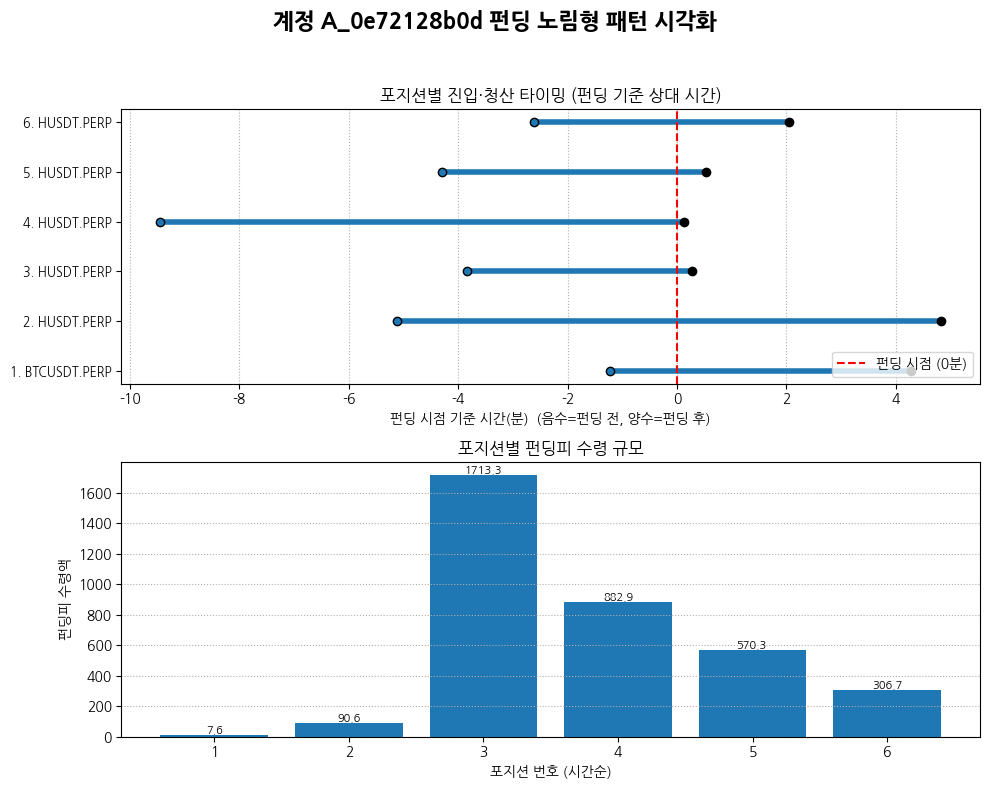

In [69]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)
fig.suptitle(f"계정 {acc_id} 펀딩 노림형 패턴 시각화", fontsize=16, fontweight='bold')

# =======================
# 1) 펀딩 기준 타임라인
# =======================
ax1 = axes[0]

y_pos = range(len(acc))

for i, row in enumerate(acc.itertuples()):
    # 포지션: 펀딩 이전(음수) ~ 이후(양수) 구간을 한 줄로 표현
    ax1.hlines(y=i, xmin=row.rel_open_min, xmax=row.rel_close_min, color='C0', linewidth=4)
    # 진입 시점 표시(파란 점)
    ax1.scatter(row.rel_open_min, i, color='C0', edgecolor='black', zorder=3)
    # 청산 시점 표시(검은 점)
    ax1.scatter(row.rel_close_min, i, color='black', zorder=3)
    # 펀딩 시점(0분) 표시(빨간 세로선은 아래에서 공통)

# 펀딩 시점(0분) 수직선
ax1.axvline(0, color='red', linestyle='--', linewidth=1.5, label='펀딩 시점 (0분)')

ax1.set_yticks(list(y_pos))
ax1.set_yticklabels([f"{i+1}. {s}" for i, s in enumerate(acc['symbol'])], fontsize=9)
ax1.set_xlabel("펀딩 시점 기준 시간(분)  (음수=펀딩 전, 양수=펀딩 후)")
ax1.set_title("포지션별 진입·청산 타이밍 (펀딩 기준 상대 시간)")
ax1.grid(True, axis='x', linestyle=':')
ax1.legend(loc='lower right')

# =======================
# 2) 포지션별 펀딩피 막대그래프
# =======================
ax2 = axes[1]

# 포지션 번호 부여 (1,2,3,...)
position_idx = range(1, len(acc) + 1)

ax2.bar(position_idx, acc['funding_fee'])
for i, (x, val) in enumerate(zip(position_idx, acc['funding_fee'])):
    ax2.text(x, val, f"{val:.1f}", ha='center', va='bottom', fontsize=8)

ax2.set_xticks(position_idx)
ax2.set_xticklabels([f"{i+1}" for i in range(len(acc))])
ax2.set_xlabel("포지션 번호 (시간순)")
ax2.set_ylabel("펀딩피 수령액")
ax2.set_title("포지션별 펀딩피 수령 규모")
ax2.grid(True, axis='y', linestyle=':')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

계정 A_0e72128b0d는
펀딩 발생 직전 2~ 9분에 포지션을 열고,
펀딩피를 수령한 후 5~10분 내에 즉시 청산하는 패턴을 반복함.

이는 제도적 수익(펀딩피)을 노린 구조적 행태이며,
펀딩 이벤트 자체를 기준으로 설계된 전형적인 펀딩 노림형 패턴으로 판단됨.